**Overview**<br>
This notebook contains code for MNIST_handwritten digit classification using fastai library.<br>There's a step by step description of each cell.<br>Let's begin!!!

First we'll add some code for updating the imported fastai library, displaying the data in jupyter notebook and taking care of warnings that may present themselves.

In [2]:
#Boilerplate code
!curl -s https://course.fast.ai/setup/colab | bash
import warnings; warnings.simplefilter('ignore')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.


Import the necessary modules and submodules. We'll use import * to import everything we might need. This practice is frowned upon in software engineering but in fastai, import * is done without compromising maintainability and  understanding. import * only imports a chosen set of symbols and keywords.

In [0]:
#making necessary imports
from fastai import *
from fastai.vision import *

Downloading and getting the data path.
MNIST handwritten_digits data is already available in fastai datasets. We'll use the same.

In [4]:
path = untar_data(URLs.MNIST)

Let's see what we got

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

The extracted data contains 2 subfolders training and testing. Looking further inside these folders we see that each folder has 10 subfolders labelled from 0 to 9. These are our labels. This style of dataset organisation is use in ImageNet.

In [6]:
train = path/'training'
test = path/'testing'
train.ls()

[PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/5')]

While performing classification tasks, it always serves well to explore the dataset. Let's check it out.

In [7]:
images = get_image_files(train/'0')
len(images)

5923

Now we'll create an ImageDataBunch object from our path. ImageDataBunch has several factory methods to get data from different specified folder structures. For our dataset, we'll use the factory method from_folder.<br>
An ImageDataBunch is a derived class of DataBunch class. DataBunch objects are used to train learner objects (models) in fastai.


In [8]:
data = ImageDataBunch.from_folder(path,train='training',valid = 'testing')
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Test: None

Let's see what our images look like.<br>
The MNIST dataset is an acronym that stands for the Modified National Institute<br> of Standards and Technology dataset. It is a dataset of 60,000 small square 28×28 pixel<br>grayscale images of handwritten single digits between 0 and 9.

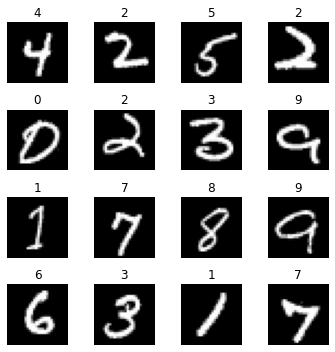

In [9]:
data.show_batch(4,figsize=(5,5))

Now, we'll use a pretrained network ready for fine tuning to make our model. The model we'll use is resnet18.<br>
The method cnn_learner downloads the pretrained weights of resnet18.<br>
We'd like to see the error rates and accuracy metrics.<br>
By default, when you call cnn_learner all layers other then the top layers are frozen. Lookup **Transfer Learning**.

In [10]:
learner = cnn_learner(data,models.resnet18,metrics=[accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Now we can use fit or fit_one_cycle to train our model. fit method uses the classic training technique, training all layers at a constant rate.<br>
One cycle policy changes the learning rate over-time for better training and that's what we're gonna use.

In [11]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.696766,0.505392,0.839800,0.160200,00:29
1,0.320941,0.176133,0.942900,0.057100,00:29
2,0.194322,0.115307,0.965400,0.034600,00:28
3,0.136863,0.085784,0.972300,0.027700,00:28
4,0.140161,0.081172,0.973500,0.026500,00:29


Let's save this model before making further changes.

In [0]:
learner.save('first-stage')

We obtained an accuracy of 97% and 0.025 error_rate. Now let's fine tune the model further and see if we can get better results.

Now the fully connected layers are well trained. Now we'll unfreeze the rest of the layers and further train the model.<br>
FastAI provides enhanced methods to implement transfer learning with something called differential learning rate. After unfreezing the rest of the network, we use lr_find and recorder.plot to plot the relation between learning rate and loss.

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


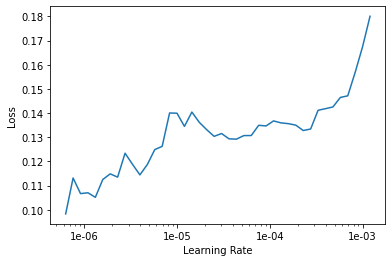

In [15]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

Now I'm not entirely sure what we're doing here. I'll get back to this.

In [17]:
learner.fit_one_cycle(4,max_lr = slice(2e-05,2e-04))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.097628,0.049771,0.983400,0.016600,00:32
1,0.072000,0.028840,0.990600,0.009400,00:31
2,0.031976,0.029222,0.990800,0.009200,00:31
3,0.015253,0.026589,0.992200,0.007800,00:32


This is better than our last model with an accuracy of 99.2%. Good Stuff.<br>Let's Save it.

In [0]:
learner.save('stage-2')

Let's see if we can get more accuracy by increasing epochs.

In [20]:
learner.load('first-stage')
learner.unfreeze()
learner.fit_one_cycle(6,max_lr=slice(2e-05,2e-04))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.104156,0.057387,0.982600,0.017400,00:31
1,0.063474,0.036922,0.987500,0.012500,00:32
2,0.043242,0.029498,0.989400,0.010600,00:32
3,0.028321,0.027364,0.990500,0.009500,00:32
4,0.012162,0.022330,0.992900,0.007100,00:32
5,0.006428,0.021719,0.993100,0.006900,00:32


This is slightly better. 99.31% accuracy as compared to 99.22%.

In [0]:
learner.save('model-3')

Let's see the images our model got wrong.

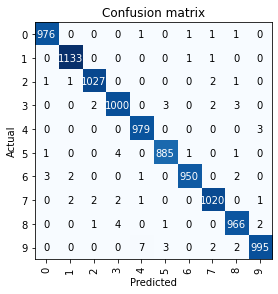

In [25]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

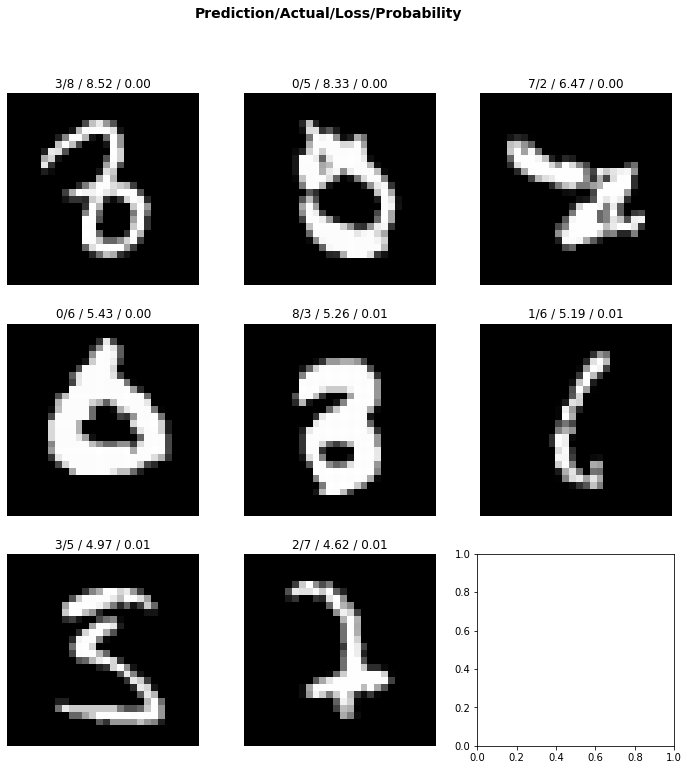

In [28]:
interp.plot_top_losses(8)

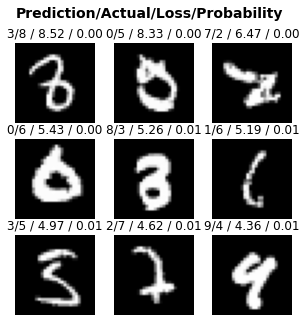

In [35]:
interp.plot_top_losses(9, figsize=(5,5))

Let's try predicting a random image

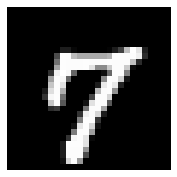

In [41]:
img = data.train_ds[13876][0]
img.show()

In [42]:
learner.predict(img)

(Category tensor(7),
 tensor(7),
 tensor([3.4208e-06, 3.7989e-06, 1.1947e-05, 2.2890e-06, 1.4057e-06, 3.6737e-05,
         1.1887e-07, 9.9988e-01, 4.9475e-05, 7.0546e-06]))

IT WORKS!!!